# Project

### 1 Load Packages

In [1]:
# ========================TensorFlow========================
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [2]:
# ========================General========================
import os
import io
import sys
import time
import json
import joblib
import pandas as pd
import numpy as np
import requests
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
# ========================Ploting========================
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
# ========================Import Picture========================
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
# ========================Data Preprocessing========================
from sklearn import preprocessing
# Encoding
from sklearn.preprocessing import LabelEncoder
# Feature Scaling
from sklearn.preprocessing import StandardScaler
# Data Split
from sklearn.model_selection import train_test_split
# ========================Modeling========================
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# KNN
from sklearn.neighbors import KNeighborsClassifier
# Decision Tree & Random Forest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# KMeans
from sklearn.cluster import KMeans
# ========================Evaluation========================
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, matthews_corrcoef, f1_score
# ========================Deep Learning========================
# MLP
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten
# ================================================

Using TensorFlow backend.


### 2 Load dataset

In [0]:
# load movie
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    # df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    df['release_year'] = pd.to_datetime(df['release_date']).apply(lambda x: int(x.year) if x==x else None)
    df['release_month'] = pd.to_datetime(df['release_date']).apply(lambda x: int(x.month) if x==x else None)
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [0]:
# load movie credits
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [0]:
# Columns that existed in IMDB version of the dataset and are gone.
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews']

# Columns in TMDb that had direct equivalents in the IMDB version. 
# These columns can be used with old kernels just by changing the names
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',  # it's possible that spoken_languages would be a better match
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}


def safe_access(container, index_values):
    # return a missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan


def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])


def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])


def convert_to_original_format(movies, credits):
    # Converts TMDb data to make it as compatible as possible with kernels built on the original version of the data.
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['companies_1'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['companies_2'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['companies_3'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [0]:
movies_url = 'https://raw.githubusercontent.com/carrickeane/INFO7390_Data_Sci/master/movie_data.csv'
credits_url = "https://raw.githubusercontent.com/carrickeane/INFO7390_Data_Sci/master/movie_credits.csv"
movies_content = requests.get(movies_url).content
credits_content = requests.get(credits_url).content

movies = load_tmdb_movies(io.StringIO(movies_content.decode('utf-8')))
credits = load_tmdb_credits(io.StringIO(credits_content.decode('utf-8')))
raw_data =convert_to_original_format(movies, credits)

### 3 Data Preprocessing
*   Handling Missing Values
*   Drop Duplication Values
*   Drop Outliers

#### 3.1 Handling Missing Values

In [7]:
raw_data.head(1)

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,release_year,release_month,country,director_name,actor_1_name,actor_2_name,actor_3_name,companies_1,companies_2,companies_3
0,0,Comedy,NaN,3924,blondie,English,Blondie,Blondie and Dagwood are about to celebrate the...,3.005,"[{'id': 5, 'logo_path': '/71BqEFAF4V3qjjMPCpLu...","[{'iso_3166_1': 'US', 'name': 'United States o...",1938-11-30,0,70.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Blondie,6.6,4,1938.0,11.0,United States of America,Frank R. Strayer,Penny Singleton,Arthur Lake,Larry Simms,Columbia Pictures,NaN,NaN


In [8]:
total_missing = raw_data.isnull().sum().sort_values(ascending=False)
percent = (raw_data.isnull().sum()/len(raw_data)).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent], axis=1, keys=['total Missing', 'Percent'])
missing_data.head(10)

,total Missing,Percent
homepage,13456,0.836816
companies_3,11917,0.741107
companies_2,8592,0.534328
tagline,8051,0.500684
companies_1,3062,0.190423
actor_3_name,1096,0.068159
country,1051,0.065361
actor_2_name,887,0.055162
director_name,738,0.045896
language,604,0.037562


In [0]:
# drop homepage & tagline
raw_data.drop(['homepage','tagline'], axis=1, inplace=True)

#### 3.2 Drop Duplication Values and Unseen Features

In [0]:
# Drop Duplication Values
drop_duplicates_subset = ('budget', 'genres', 'id', 'plot_keywords', 'language', 'original_title','overview', 'popularity','release_date', 'gross', 'duration','status','movie_title','vote_average','num_voted_users')
raw_data.drop_duplicates(subset=drop_duplicates_subset, keep='first', inplace=True)

In [0]:
# Drop features that only know after movie release
raw_data.drop(['num_voted_users', 'gross', 'popularity'], axis=1, inplace=True)

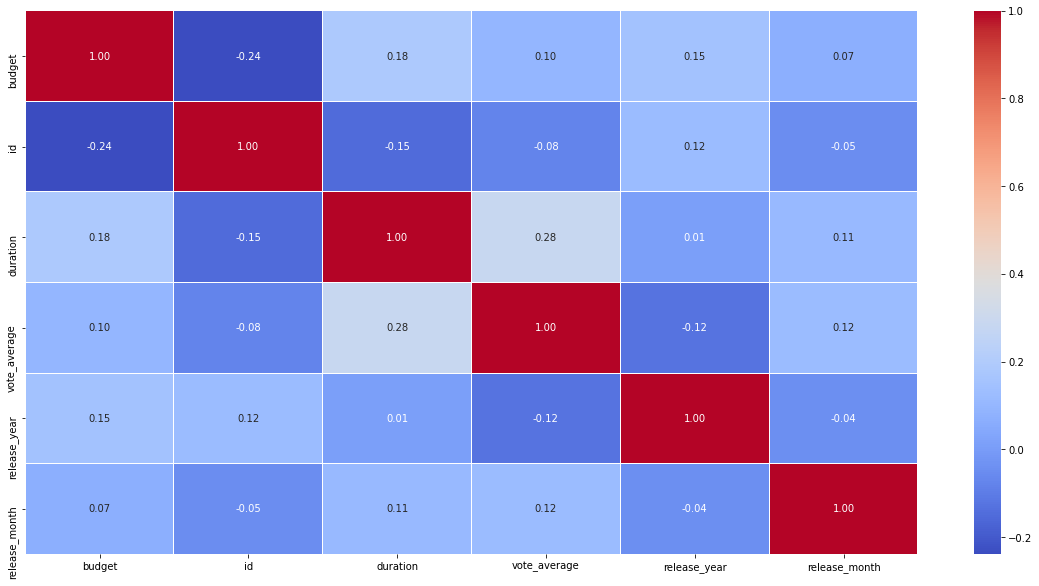

In [12]:
# Correlation matrix between numerical values
plt.figure(figsize = (20,10))
g = sns.heatmap(raw_data[list(raw_data)].corr(),annot=True, fmt = ".2f", cmap = "coolwarm",linewidths= 0.01)

#### 3.3 Drop Outliers

<Figure size 1080x720 with 0 Axes>

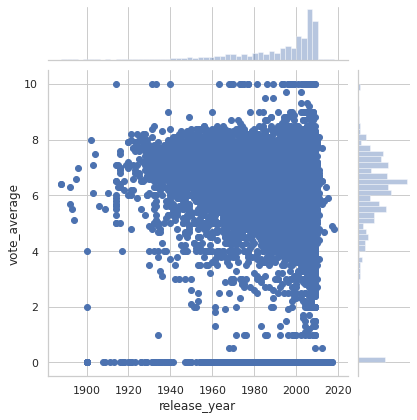

In [13]:
# release_year and vote_average
plt.figure(figsize=(15,10))
sns.set(style="whitegrid")
sns.jointplot(x="release_year", y="vote_average", data=raw_data)
plt.show()

In [14]:
# Drop rows in dataset containing 0 and below vote average
before_rows = len(raw_data)
raw_data = raw_data[raw_data['vote_average'] > 0]
print('Delete {} rows;\nCurrent Total rows: {}'.format(before_rows-len(raw_data), len(raw_data)))

Delete 1005 rows;
Current Total rows: 15075


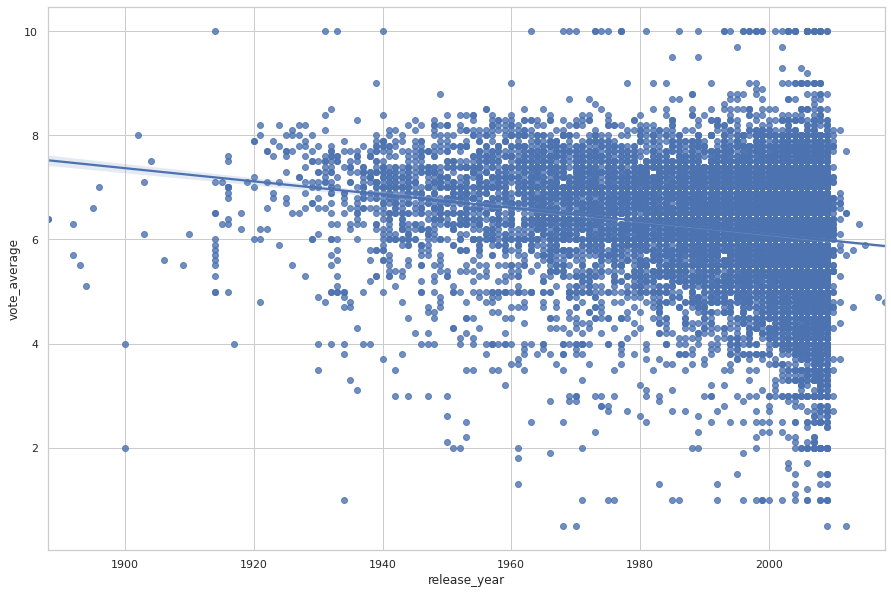

In [15]:
plt.figure(figsize = (15,10))
sns.set(style="whitegrid")
sns.regplot(x="release_year", y="vote_average", data=raw_data)
plt.show()

<Figure size 1080x720 with 0 Axes>

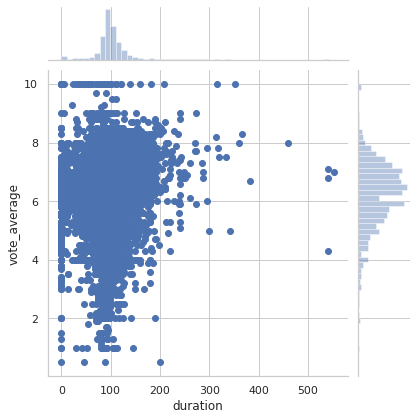

In [16]:
# Duration and vote_average
plt.figure(figsize = (15,10))
sns.set(style="whitegrid")
sns.jointplot(x="duration", y="vote_average", data=raw_data)
plt.show()

In [17]:
# Most of directors decide to make 90-120 mins movie, 0-5 duration is not possible
# Drop rows in dataset of which duration <= 5
before_rows = len(raw_data)
raw_data = raw_data[raw_data['duration'] > 5]
print('Delete {} rows;\nCurrent Total rows: {}'.format(before_rows-len(raw_data), len(raw_data)))

Delete 237 rows;
Current Total rows: 14838


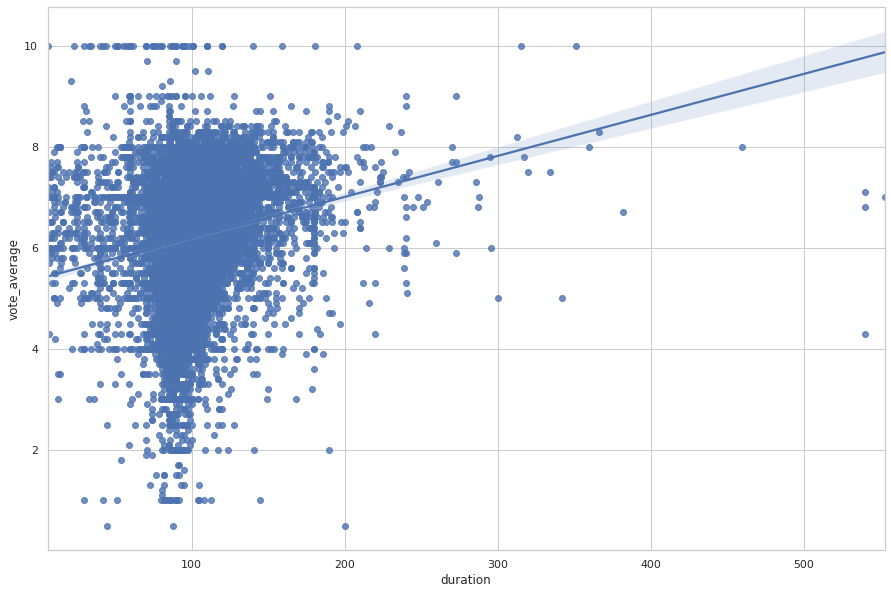

In [18]:
plt.figure(figsize=(15,10))
sns.set(style="whitegrid")
sns.regplot(x="duration", y="vote_average", data=raw_data)
plt.show()

### 4 Data Wrangling: Define a movie is successful or unsuccessful and edit features
*   Define Label
*   Budget
*   Release Year
*   Duration
*   Genres
*   Director
*   Actor
*   Company

#### 4.1 Define Label

In [19]:
# Total columns fot dataset
raw_data.columns

Index(['budget', 'genres', 'id', 'plot_keywords', 'language', 'original_title',
       'overview', 'production_companies', 'production_countries',
       'release_date', 'duration', 'spoken_languages', 'status', 'movie_title',
       'vote_average', 'release_year', 'release_month', 'country',
       'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name',
       'companies_1', 'companies_2', 'companies_3'],
      dtype='object')

In [20]:
raw_data.describe(percentiles=[.10,.25,.5,.75,.9,.99], include=['float','int'])

,budget,id,duration,vote_average,release_year,release_month
count,1.483800e+04,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000
mean,8.095092e+06,13664.260884,101.076156,6.203019,1992.349306,6.547446
std,2.203237e+07,7616.606350,26.936627,1.152474,18.705888,3.621174
min,0.000000e+00,2.000000,6.000000,0.500000,1892.000000,1.000000
10%,0.000000e+00,2160.700000,80.000000,4.700000,1964.000000,1.000000
25%,0.000000e+00,8498.500000,90.000000,5.600000,1984.000000,3.000000
50%,0.000000e+00,13719.500000,98.000000,6.300000,2000.000000,7.000000
75%,3.500000e+06,19844.750000,110.000000,7.000000,2006.000000,10.000000
90%,2.500000e+07,24422.600000,127.000000,7.500000,2008.000000,11.000000
99%,1.050000e+08,26575.630000,183.630000,8.400000,2009.000000,12.000000


In [21]:
# For this kernel, successful movies is a movie which got vote_score more than vote_score mean
raw_data['success'] = raw_data['vote_average'].map(lambda s :1  if s >= raw_data['vote_average'].mean() else 0)
raw_data.success.value_counts()

1    7867
0    6971
Name: success, dtype: int64

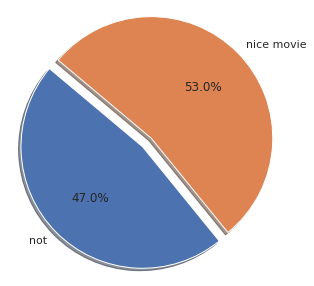

In [22]:
# Data to plot
plt.figure(figsize=(5,5))
labels =["not","nice movie"]
sizes = raw_data['success'].value_counts(sort = False)
explode = (0.1,0)  # explode 1st slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140,)
plt.axis('equal')
plt.show()

#### 4.2 Budget

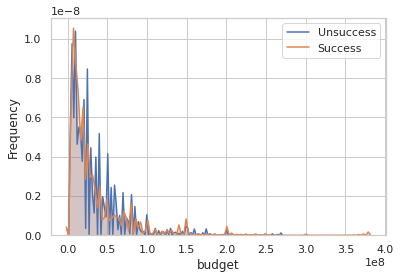

In [23]:
# budget distibution
g = sns.kdeplot(raw_data.budget[(raw_data["success"] == 0) ], shade = True)
g = sns.kdeplot(raw_data.budget[(raw_data["success"] == 1) ], shade= True)
g.set_xlabel("budget")
g.set_ylabel("Frequency")
g = g.legend(["Unsuccess","Success"])

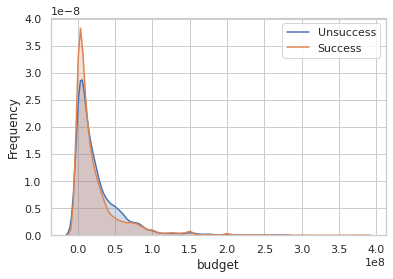

In [24]:
# Non-zero budget distibution
g = sns.kdeplot(raw_data.budget[raw_data.budget>0][(raw_data["success"] == 0) ], shade = True)
g = sns.kdeplot(raw_data.budget[raw_data.budget>0][(raw_data["success"] == 1) ], shade= True)
g.set_xlabel("budget")
g.set_ylabel("Frequency")
g = g.legend(["Unsuccess","Success"])

In [0]:
import statistics

In [0]:
# The Q1,median,Q3,95% of budget of non-zero movies
non_zero_budget_Q1 = raw_data.budget[raw_data.budget>0].quantile(0.25)
non_zero_budget_median = raw_data.budget[raw_data.budget>0].quantile(0.5)
non_zero_budget_Q3 = raw_data.budget[raw_data.budget>0].quantile(0.75)
non_zero_budget_95 = raw_data.budget[raw_data.budget>0].quantile(0.95)

In [0]:
# Create new feature of budget 
raw_data['VeryLowBudget'] = raw_data['budget'].map(lambda s: 1 if s < non_zero_budget_Q1 else 0)
raw_data['LowBudget'] = raw_data['budget'].map(lambda s: 1 if non_zero_budget_Q1 <= s < non_zero_budget_median else 0)
raw_data['MedBudget'] = raw_data['budget'].map(lambda s: 1 if  non_zero_budget_median <= s < non_zero_budget_Q3 else 0)
raw_data['HighBudget'] = raw_data['budget'].map(lambda s: 1 if non_zero_budget_Q3 <= s < non_zero_budget_95 else 0)
raw_data['VeryHighBudget'] = raw_data['budget'].map(lambda s: 1 if s >= non_zero_budget_95 else 0)

#### 4.3 Release Year

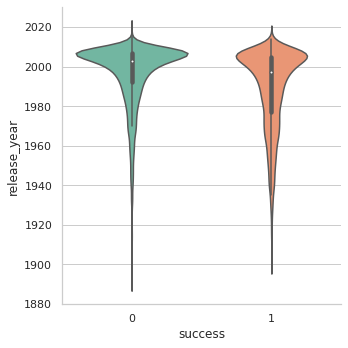

In [28]:
# Release Year Distribution
g = sns.factorplot(y="release_year",x="success",data=raw_data,kind="violin", palette = "Set2")

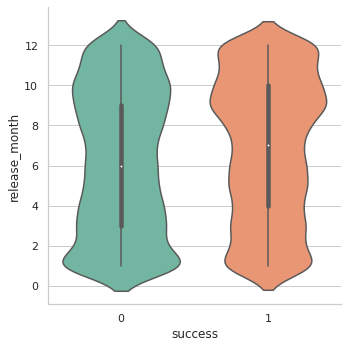

In [29]:
# Release Month Distribution
g = sns.factorplot(y="release_month",x="success",data=raw_data,kind="violin", palette = "Set2")

#### 4.4 Duration

In [30]:
before = len(raw_data)
raw_data = raw_data[np.isfinite(raw_data['duration'])]
print('Delete {} rows;\nCurrent Total rows: {}'.format(before-len(raw_data), len(raw_data)))

Delete 0 rows;
Current Total rows: 14838


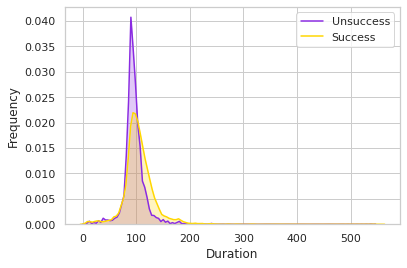

In [31]:
# duration distibution 
g = sns.kdeplot(raw_data.duration[(raw_data["success"] == 0) ], color="blueviolet", shade = True)
g = sns.kdeplot(raw_data.duration[(raw_data["success"] == 1) ], ax =g, color="gold", shade= True)
g.set_xlabel("Duration")
g.set_ylabel("Frequency")
g = g.legend(["Unsuccess","Success"])

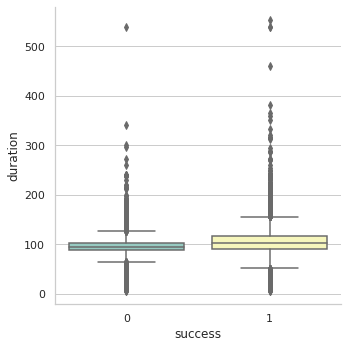

In [32]:
g = sns.factorplot(x="success", y = "duration",data = raw_data, kind="box", palette = "Set3")

In [0]:
duration_Q1=raw_data.duration.quantile(q=0.25)
duration_median=raw_data.duration.quantile(q=0.5)
duration_Q3=raw_data.duration.quantile(q=0.75)

In [0]:
'''
Based on common sence
duration <90          => Short Movie
90 <= duration < 120  => Normal Movie
120 <= duration       => Long Movie
'''
raw_data['ShortMovie'] = raw_data['duration'].map(lambda s: 1 if s < 90 else 0)
raw_data['NormalMovie'] = raw_data['duration'].map(lambda s: 1 if 90 <= s < 120 else 0)
raw_data['LongMovie'] = raw_data['duration'].map(lambda s: 1 if s >= 120 else 0)

#### 4.5 Genres

#### 4.6 Director

#### 4.7 Actor

#### 4.8 Company

### 5 Modeling
*   K-Nearest Neighbors
*   Decision Tree
*   Random Forest
*   Gradient Boosting
*   Conclusion Model Performance
*   Model Test

### 6 Modeling
*   Feature Importance